# indicators

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import itertools
import talib
import ta

In [3]:
close = pd.DataFrame({
    'a': [1., 2., 3., 4., 5.],
    'b': [5., 4., 3., 2., 1.],
    'c': [1., 2., 3., 2., 1.]
}, index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
]))
np.random.seed(42)
high = close * np.random.uniform(1, 1.1, size=close.shape)
low = close * np.random.uniform(0.9, 1, size=close.shape)
volume = close * 0 + np.random.randint(10, 100, size=close.shape).astype(float)

In [4]:
big_close = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_close.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_high = big_close * np.random.uniform(1, 1.1, size=big_close.shape)
big_low = big_close * np.random.uniform(0.9, 1, size=big_close.shape)
big_volume = big_close * 0 + np.random.randint(10, 100, size=big_close.shape).astype(float)

In [5]:
close_ts = pd.Series([1, 2, 3, 4, 3, 2, 1], index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5),
    datetime(2018, 1, 6),
    datetime(2018, 1, 7)
]))
high_ts = close_ts * 1.1
low_ts = close_ts * 0.9
volume_ts = pd.Series([4, 3, 2, 1, 2, 3, 4], index=close_ts.index)

## IndicatorFactory

In [9]:
def apply_func(i, ts, p, a, b=100):
    return ts * p[i] + a + b

@njit
def apply_func_nb(i, ts, p, a, b):
    return ts * p[i] + a + b # numba doesn't support **kwargs

# Custom function can be anything that takes time series, params and other arguments, and returns outputs
def custom_func(ts, p, *args, **kwargs):
    return vbt.base.combine_fns.apply_and_concat_one(len(p), apply_func, ts, p, *args, **kwargs)

@njit
def custom_func_nb(ts, p, *args):
    return vbt.base.combine_fns.apply_and_concat_one_nb(len(p), apply_func_nb, ts, p, *args)

F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_custom_func(custom_func, var_args=True)
      .run(close, [0, 1], 10, b=100).out)
print(F.from_custom_func(custom_func_nb, var_args=True)
      .run(close, [0, 1], 10, 100).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0


In [10]:
# Apply function is performed on each parameter individually, and each output is then stacked for you
# Apply functions are less customizable than custom functions, but are simpler to write
def apply_func(ts, p, a, b=100):
    return ts * p + a + b

@njit
def apply_func_nb(ts, p, a, b):
    return ts * p + a + b  # numba doesn't support **kwargs
     
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(apply_func, var_args=True)
      .run(close, [0, 1], 10, b=100).out)
print(F.from_apply_func(apply_func_nb, var_args=True)
      .run(close, [0, 1], 10, 100).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0


In [11]:
# test *args
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a: ts * p + a, var_args=True)
      .run(close, [0, 1, 2], 3).out) 
print(F.from_apply_func(njit(lambda ts, p, a: ts * p + a), var_args=True)
      .run(close, [0, 1, 2], 3).out)

custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0
custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0


In [12]:
# test **kwargs
# Numba doesn't support kwargs out of the box
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a=1: ts * p + a)
      .run(close, [0, 1, 2], a=3).out) 

custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0


In [13]:
# test no inputs
F = vbt.IndicatorFactory(param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda p: np.full((3, 3), p))
      .run([0, 1]).out)
print(F.from_apply_func(njit(lambda p: np.full((3, 3), p)))
      .run([0, 1]).out)

custom_p  0        1      
          0  1  2  0  1  2
0         0  0  0  1  1  1
1         0  0  0  1  1  1
2         0  0  0  1  1  1
custom_p  0        1      
          0  1  2  0  1  2
0         0  0  0  1  1  1
1         0  0  0  1  1  1
2         0  0  0  1  1  1


In [14]:
# test no inputs with input_shape, input_index and input_columns
F = vbt.IndicatorFactory(param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p))
      .run(0, input_shape=(5,)).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)))
      .run(0, input_shape=(5,)).out)

print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p))
      .run([0, 1], input_shape=(5,)).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)))
      .run([0, 1], input_shape=(5,)).out)

print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p))
      .run([0, 1], input_shape=(5, 3), input_index=close.index, input_columns=close.columns).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)))
      .run([0, 1], input_shape=(5, 3), input_index=close.index, input_columns=close.columns).out)

0    0
1    0
2    0
3    0
4    0
dtype: int64
0    0
1    0
2    0
3    0
4    0
dtype: int64
custom_p  0  1
0         0  1
1         0  1
2         0  1
3         0  1
4         0  1
custom_p  0  1
0         0  1
1         0  1
2         0  1
3         0  1
4         0  1
custom_p    0        1      
            a  b  c  a  b  c
2018-01-01  0  0  0  1  1  1
2018-01-02  0  0  0  1  1  1
2018-01-03  0  0  0  1  1  1
2018-01-04  0  0  0  1  1  1
2018-01-05  0  0  0  1  1  1
custom_p    0        1      
            a  b  c  a  b  c
2018-01-01  0  0  0  1  1  1
2018-01-02  0  0  0  1  1  1
2018-01-03  0  0  0  1  1  1
2018-01-04  0  0  0  1  1  1
2018-01-05  0  0  0  1  1  1


In [15]:
# test multiple inputs
F = vbt.IndicatorFactory(input_names=['ts1', 'ts2'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts1, ts2, p: ts1 * ts2 * p)
      .run(close, high, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts1, ts2, p: ts1 * ts2 * p))
      .run(close, high, [0, 1]).out)

custom_p      0                    1                     
              a    b    c          a          b         c
2018-01-01  0.0  0.0  0.0   1.037454  27.376786  1.073199
2018-01-02  0.0  0.0  0.0   4.239463  16.249630  4.062398
2018-01-03  0.0  0.0  0.0   9.052275   9.779559  9.541004
2018-01-04  0.0  0.0  0.0  17.132916   4.008234  4.387964
2018-01-05  0.0  0.0  0.0  27.081107   1.021234  1.018182
custom_p      0                    1                     
              a    b    c          a          b         c
2018-01-01  0.0  0.0  0.0   1.037454  27.376786  1.073199
2018-01-02  0.0  0.0  0.0   4.239463  16.249630  4.062398
2018-01-03  0.0  0.0  0.0   9.052275   9.779559  9.541004
2018-01-04  0.0  0.0  0.0  17.132916   4.008234  4.387964
2018-01-05  0.0  0.0  0.0  27.081107   1.021234  1.018182


In [16]:
# test no params
F = vbt.IndicatorFactory(input_names=['ts'], output_names=['out'])
print(F.from_apply_func(lambda ts: ts)
      .run(close).out)
print(F.from_apply_func(njit(lambda ts: ts))
      .run(close).out)

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0


In [17]:
# test no inputs and no params
F = vbt.IndicatorFactory(output_names=['out'])
print(F.from_apply_func(lambda: np.full((3, 3), 1))
      .run().out)
print(F.from_apply_func(njit(lambda: np.full((3, 3), 1)))
      .run().out)

   0  1  2
0  1  1  1
1  1  1  1
2  1  1  1
   0  1  2
0  1  1  1
1  1  1  1
2  1  1  1


In [18]:
# test multiple params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run(close, np.asarray([0, 1]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run(close, np.asarray([0, 1]), np.asarray([2, 3])).out)

custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0  10.0  2.0   4.0  20.0   4.0
2018-01-02   4.0   8.0  4.0   8.0  16.0   8.0
2018-01-03   6.0   6.0  6.0  12.0  12.0  12.0
2018-01-04   8.0   4.0  4.0  16.0   8.0   8.0
2018-01-05  10.0   2.0  2.0  20.0   4.0   4.0
custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0  10.0  2.0   4.0  20.0   4.0
2018-01-02   4.0   8.0  4.0   8.0  16.0   8.0
2018-01-03   6.0   6.0  6.0  12.0  12.0  12.0
2018-01-04   8.0   4.0  4.0  16.0   8.0   8.0
2018-01-05  10.0   2.0  2.0  20.0   4.0   4.0


In [19]:
# test param_settings array_like
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), 
                        param_settings={'p1': {'array_like': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), 
                        param_settings={'p1': {'array_like': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out)

custom_p1  mix_0             mix_1            
custom_p2      2                 3            
               a     b     c     a     b     c
2018-01-01   2.0  15.0   4.0   3.0  20.0   5.0
2018-01-02   4.0  12.0   8.0   6.0  16.0  10.0
2018-01-03   6.0   9.0  12.0   9.0  12.0  15.0
2018-01-04   8.0   6.0   8.0  12.0   8.0  10.0
2018-01-05  10.0   3.0   4.0  15.0   4.0   5.0
custom_p1  mix_0             mix_1            
custom_p2      2                 3            
               a     b     c     a     b     c
2018-01-01   2.0  15.0   4.0   3.0  20.0   5.0
2018-01-02   4.0  12.0   8.0   6.0  16.0  10.0
2018-01-03   6.0   9.0  12.0   9.0  12.0  15.0
2018-01-04   8.0   6.0   8.0  12.0   8.0  10.0
2018-01-05  10.0   3.0   4.0  15.0   4.0   5.0


In [20]:
# test param_settings bc_to_input
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), 
                        param_settings={'p1': {'array_like': True, 'bc_to_input': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), 
                        param_settings={'p1': {'array_like': True, 'bc_to_input': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out)

custom_p1  mix_0             mix_1            
custom_p2      2                 3            
               a     b     c     a     b     c
2018-01-01   2.0  15.0   4.0   3.0  20.0   5.0
2018-01-02   4.0  12.0   8.0   6.0  16.0  10.0
2018-01-03   6.0   9.0  12.0   9.0  12.0  15.0
2018-01-04   8.0   6.0   8.0  12.0   8.0  10.0
2018-01-05  10.0   3.0   4.0  15.0   4.0   5.0
custom_p1  mix_0             mix_1            
custom_p2      2                 3            
               a     b     c     a     b     c
2018-01-01   2.0  15.0   4.0   3.0  20.0   5.0
2018-01-02   4.0  12.0   8.0   6.0  16.0  10.0
2018-01-03   6.0   9.0  12.0   9.0  12.0  15.0
2018-01-04   8.0   6.0   8.0  12.0   8.0  10.0
2018-01-05  10.0   3.0   4.0  15.0   4.0   5.0


In [21]:
# test param product
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run(close, [0, 1], [2, 3], param_product=True).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run(close, [0, 1], [2, 3], param_product=True).out)

custom_p1      0                                 1                         \
custom_p2      2                3                2                3         
               a     b    c     a     b    c     a     b    c     a     b   
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0   3.0  15.0  3.0   4.0  20.0   
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0   6.0  12.0  6.0   8.0  16.0   
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0   9.0   9.0  9.0  12.0  12.0   
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0  12.0   6.0  6.0  16.0   8.0   
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0  15.0   3.0  3.0  20.0   4.0   

custom_p1         
custom_p2         
               c  
2018-01-01   4.0  
2018-01-02   8.0  
2018-01-03  12.0  
2018-01-04   8.0  
2018-01-05   4.0  
custom_p1      0                                 1                         \
custom_p2      2                3                2                3         
               a     b    c     a     b    c     a     b    c     a     b   


In [22]:
# test default params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1]).out)

custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0


In [23]:
# test hide_params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), hide_params=['p2'])
      .run(close, [0, 1], 2).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), hide_params=['p2'])
      .run(close, [0, 1], 2).out)

custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0


In [24]:
# test hide_default
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1], hide_default=False).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1], hide_default=False).out)
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1], hide_default=True).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1], hide_default=True).out)

custom_p1      0                1           
custom_p2      2                2           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
custom_p2      2                2           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05

In [25]:
# test multiple outputs
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['o1', 'o2'])
print(F.from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))
      .run(close, [0, 1]).o1)
print(F.from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))
      .run(close, [0, 1]).o2)
print(F.from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))
      .run(close, [0, 1]).o1)
print(F.from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))
      .run(close, [0, 1]).o2)

custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0 

In [26]:
# test in-place outputs
def apply_func(ts, ts_out, p):
    ts_out[:, 0] = p
    return ts * p

F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'], in_output_names=['ts_out'])
print(F.from_apply_func(apply_func)
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func))
      .run(close, [0, 1]).ts_out)

print(F.from_apply_func(apply_func, in_output_settings={'ts_out': {'dtype': np.int_}})
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func), in_output_settings={'ts_out': {'dtype': np.int_}})
      .run(close, [0, 1]).ts_out)

print(F.from_apply_func(apply_func, ts_out=-1)
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func), ts_out=-1)
      .run(close, [0, 1]).ts_out)

custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-02  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-03  0.0  0.0  0.0  1.0  2.0  3.0
2018-01-04  0.0  5.0  5.0  1.0  3.0  2.0
2018-01-05  0.0  1.0  2.0  1.0  2.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-02  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-03  0.0  0.0  0.0  1.0  2.0  3.0
2018-01-04  0.0  5.0  5.0  1.0  3.0  2.0
2018-01-05  0.0  1.0  2.0  1.0  2.0  1.0
custom_p    0                                            1  \
            a                    b                    c  a   
2018-01-01  0                    0                    0  1   
2018-01-02  0                    0                    0  1   
2018-01-03  0                    0                    0  1   
2018-01-04  0  4617315517961601024  4617315517961601024  1   
2018-01-05  0  4607182418800017408  461168601842738790

In [27]:
# test pass_kwargs
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a, kw: ts * p + a + kw, pass_kwargs=['kw'], var_args=True)
      .run(close, [0, 1, 2], 3, kw=10).out) 
print(F.from_apply_func(njit(lambda ts, p, a, kw: ts * p + a + kw), pass_kwargs=['kw'], var_args=True)
      .run(close, [0, 1, 2], 3, kw=10).out)

custom_p       0                 1                 2            
               a     b     c     a     b     c     a     b     c
2018-01-01  13.0  13.0  13.0  14.0  18.0  14.0  15.0  23.0  15.0
2018-01-02  13.0  13.0  13.0  15.0  17.0  15.0  17.0  21.0  17.0
2018-01-03  13.0  13.0  13.0  16.0  16.0  16.0  19.0  19.0  19.0
2018-01-04  13.0  13.0  13.0  17.0  15.0  15.0  21.0  17.0  17.0
2018-01-05  13.0  13.0  13.0  18.0  14.0  14.0  23.0  15.0  15.0
custom_p       0                 1                 2            
               a     b     c     a     b     c     a     b     c
2018-01-01  13.0  13.0  13.0  14.0  18.0  14.0  15.0  23.0  15.0
2018-01-02  13.0  13.0  13.0  15.0  17.0  15.0  17.0  21.0  17.0
2018-01-03  13.0  13.0  13.0  16.0  16.0  16.0  19.0  19.0  19.0
2018-01-04  13.0  13.0  13.0  17.0  15.0  15.0  21.0  17.0  17.0
2018-01-05  13.0  13.0  13.0  18.0  14.0  14.0  23.0  15.0  15.0


In [28]:
# test caching func
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, param, c: ts * param + c, cache_func=lambda ts, params: 100)
      .run(close, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts, param, c: ts * param + c), cache_func=njit(lambda ts, params: 100))
      .run(close, [0, 1]).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  100.0  100.0  100.0  101.0  105.0  101.0
2018-01-02  100.0  100.0  100.0  102.0  104.0  102.0
2018-01-03  100.0  100.0  100.0  103.0  103.0  103.0
2018-01-04  100.0  100.0  100.0  104.0  102.0  102.0
2018-01-05  100.0  100.0  100.0  105.0  101.0  101.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  100.0  100.0  100.0  101.0  105.0  101.0
2018-01-02  100.0  100.0  100.0  102.0  104.0  102.0
2018-01-03  100.0  100.0  100.0  103.0  103.0  103.0
2018-01-04  100.0  100.0  100.0  104.0  102.0  102.0
2018-01-05  100.0  100.0  100.0  105.0  101.0  101.0


In [29]:
# test run_combs
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[0].out)
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[1].out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[0].out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[1].out)

i1_p1          0                                 1            
i1_p2          3                                 4            
               a     b    c     a     b    c     a     b     c
2018-01-01   3.0  15.0  3.0   3.0  15.0  3.0   5.0  25.0   5.0
2018-01-02   6.0  12.0  6.0   6.0  12.0  6.0  10.0  20.0  10.0
2018-01-03   9.0   9.0  9.0   9.0   9.0  9.0  15.0  15.0  15.0
2018-01-04  12.0   6.0  6.0  12.0   6.0  6.0  20.0  10.0  10.0
2018-01-05  15.0   3.0  3.0  15.0   3.0  3.0  25.0   5.0   5.0
i2_p1          1                 2                              
i2_p2          4                 5                              
               a     b     c     a     b     c     a     b     c
2018-01-01   5.0  25.0   5.0   7.0  35.0   7.0   7.0  35.0   7.0
2018-01-02  10.0  20.0  10.0  14.0  28.0  14.0  14.0  28.0  14.0
2018-01-03  15.0  15.0  15.0  21.0  21.0  21.0  21.0  21.0  21.0
2018-01-04  20.0  10.0  10.0  28.0  14.0  14.0  28.0  14.0  14.0
2018-01-05  25.0   5.0   5.0  35.0   7.0 

In [30]:
from collections import namedtuple

TestEnum = namedtuple('TestEnum', ['Hello', 'World'])(0, 1)
# test attr_settings
F = vbt.IndicatorFactory(
    input_names=['ts'], output_names=['o1', 'o2'], in_output_names=['ts_out'],
    attr_settings={
        'ts': {'dtype': None}, 
        'o1': {'dtype': np.float_}, 
        'o2': {'dtype': np.bool_}, 
        'ts_out': {'dtype': TestEnum}
    }
)
dir(F.from_apply_func(lambda ts, ts_out: (ts + ts_out, ts + ts_out)).run(close))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_config',
 '_iloc',
 '_indexing_func',
 '_indexing_kwargs',
 '_input_mapper',
 '_level_names',
 '_loc',
 '_o1',
 '_o2',
 '_run',
 '_short_name',
 '_ts',
 '_ts_out',
 '_wrapper',
 'config',
 'copy',
 'iloc',
 'input_names',
 'level_names',
 'loc',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o2',
 'o2_and',
 'o2_or',
 'o2_xor',
 'output_flags',
 'output_names',
 'param_names',
 'regroup',
 'run',
 'select_series',
 'short_name',
 'ts',
 'ts_above',
 'ts_below',
 'ts_equal',
 'ts_out',
 'ts_out_readable',
 'wrapper',
 'xs']

In [31]:
CustomInd = vbt.IndicatorFactory(
    input_names=['ts1', 'ts2'],
    param_names=['p1', 'p2'],
    output_names=['o1', 'o2']
).from_apply_func(lambda ts1, ts2, p1, p2: (ts1 * p1, ts2 * p2))

In [32]:
dir(CustomInd) # you can list here all of the available tools

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_indexing_func',
 '_run',
 '_run_combs',
 'config',
 'copy',
 'iloc',
 'input_names',
 'level_names',
 'loc',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o2',
 'o2_above',
 'o2_below',
 'o2_equal',
 'output_flags',
 'output_names',
 'p1_array',
 'p1_loc',
 'p2_array',
 'p2_loc',
 'param_names',
 'regroup',
 'run',
 'run_combs',
 'select_series',
 'short_name',
 'ts1',
 'ts1_above',
 'ts1_below',
 'ts1_equal',
 'ts2',
 'ts2_above',
 'ts2_below',
 'ts2_equal',
 'tuple_loc',
 'wrapper',
 'xs']

In [33]:
custom_ind = CustomInd.run(close, high, [1, 2], [3, 4])
big_custom_ind = CustomInd.run(big_close, big_high, [1, 2], [3, 4])

In [34]:
print(custom_ind.wrapper.index) # subclasses ArrayWrapper
print(custom_ind.wrapper.columns)
print(custom_ind.wrapper.ndim)
print(custom_ind.wrapper.shape)
print(custom_ind.wrapper.freq)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq=None)
MultiIndex([(1, 3, 'a'),
            (1, 3, 'b'),
            (1, 3, 'c'),
            (2, 4, 'a'),
            (2, 4, 'b'),
            (2, 4, 'c')],
           names=['custom_p1', 'custom_p2', None])
2
(5, 6)
1 days 00:00:00


In [35]:
# not changed during indexing
print(custom_ind.short_name)
print(custom_ind.level_names)
print(custom_ind.input_names)
print(custom_ind.param_names)
print(custom_ind.output_names)
print(custom_ind.output_flags)
print(custom_ind.p1_array)
print(custom_ind.p2_array)

custom
['custom_p1', 'custom_p2']
['ts1', 'ts2']
['p1', 'p2']
['o1', 'o2']
{}
[1, 2]
[3, 4]


### Pandas indexing

In [36]:
print(custom_ind._ts1)
print(custom_ind.ts1)

print(custom_ind.ts1.iloc[:, 0])
print(custom_ind.iloc[:, 0].ts1)

print(custom_ind.ts1.iloc[:, [0]])
print(custom_ind.iloc[:, [0]].ts1)

print(custom_ind.ts1.iloc[:2, :])
print(custom_ind.iloc[:2, :].ts1)

[[1. 5. 1.]
 [2. 4. 2.]
 [3. 3. 3.]
 [4. 2. 2.]
 [5. 1. 1.]]
custom_p1     1              2          
custom_p2     3              4          
              a    b    c    a    b    c
2018-01-01  1.0  5.0  1.0  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0  5.0  1.0  1.0
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
custom_p1     1
custom_p2     3
              a
2018-01-01  1.0
2018-01-02  2.0
2018-01-03  3.0
2018-01-04  4.0
2018-01-05  5.0
custom_p1     1
custom_p2     3
              a
2018-01-01  1.0
2018-01-02  2.0
2018-01-03  3.0
2018-01-04  4.0
2018-01-05  5.0
custom_p1     1              2          
custom_p2     3              4          
              a    b    c    

In [34]:
print(custom_ind.o1.iloc[:, 0])
%timeit big_custom_ind.o1.iloc[:, 0] # benchmark, 1 column

print(custom_ind.iloc[:, 0].o1) # performed on the object itself
%timeit big_custom_ind.iloc[:, 0] # slower since it forwards the operation to each dataframe

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
260 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
1.46 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
print(custom_ind.o1.iloc[:, np.arange(3)])
%timeit big_custom_ind.o1.iloc[:, np.arange(1000)] # 1000 columns

print(custom_ind.iloc[:, np.arange(3)].o1)
%timeit big_custom_ind.iloc[:, np.arange(1000)]

custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
3.36 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
38 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
print(custom_ind.o1.loc[:, (1, 3, 'a')])
%timeit big_custom_ind.o1.loc[:, (1, 3, 0)] # 1 column

print(custom_ind.loc[:, (1, 3, 'a')].o1)
%timeit big_custom_ind.loc[:, (1, 3, 0)]

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
323 µs ± 9.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
1.67 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(custom_ind.o1.loc[:, (1, 3)])
%timeit big_custom_ind.o1.loc[:, 1] # 1000 columns

print(custom_ind.loc[:, (1, 3)].o1)
%timeit big_custom_ind.loc[:, 1]

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
360 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
14.4 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(custom_ind.o1.xs(1, axis=1, level=0))
%timeit big_custom_ind.o1.xs(1, axis=1, level=0) # 1000 columns

print(custom_ind.xs(1, axis=1, level=0).o1)
%timeit big_custom_ind.xs(1, axis=1, level=0)

custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
361 µs ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
14.9 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Parameter indexing

In [39]:
# Indexing by parameter
print(custom_ind._p1_mapper)
print(custom_ind.p1_loc[2].o1)
print(custom_ind.p1_loc[1:2].o1)
print(custom_ind.p1_loc[[1, 1, 1]].o1)

Int64Index([1, 1, 1, 2, 2, 2], dtype='int64')
custom_p2      4           
               a     b    c
2018-01-01   2.0  10.0  2.0
2018-01-02   4.0   8.0  4.0
2018-01-03   6.0   6.0  6.0
2018-01-04   8.0   4.0  4.0
2018-01-05  10.0   2.0  2.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  5.0  1.0   2.0  10.0  2.0
2018-01-02  2.0  4.0  2.0   4.0   8.0  4.0
2018-01-03  3.0  3.0  3.0   6.0   6.0  6.0
2018-01-04  4.0  2.0  2.0   8.0   4.0  4.0
2018-01-05  5.0  1.0  1.0  10.0   2.0  2.0
custom_p1     1                                        
custom_p2     3                                        
              a    b    c    a    b    c    a    b    c
2018-01-01  1.0  5.0  1.0  1.0  5.0  1.0  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0  2.0  4.0  2.0  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0  4.0  2.0  2.0  4.0  2.0  2.0
2018-01-05  5.0  1.0  

In [40]:
%timeit big_custom_ind.p1_loc[1] # 1000 columns
%timeit big_custom_ind.p1_loc[np.full(10, 1)] # 10000 columns

19.4 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
263 ms ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
print(custom_ind._tuple_mapper)
print(custom_ind.tuple_loc[(1, 3)].o1)
print(custom_ind.tuple_loc[(1, 3):(2, 4)].o1)

[(1, 3), (1, 3), (1, 3), (2, 4), (2, 4), (2, 4)]
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  5.0  1.0   2.0  10.0  2.0
2018-01-02  2.0  4.0  2.0   4.0   8.0  4.0
2018-01-03  3.0  3.0  3.0   6.0   6.0  6.0
2018-01-04  4.0  2.0  2.0   8.0   4.0  4.0
2018-01-05  5.0  1.0  1.0  10.0   2.0  2.0


In [42]:
%timeit big_custom_ind.tuple_loc[(1, 3)]
%timeit big_custom_ind.tuple_loc[[(1, 3)] * 10]

27.5 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.55 times longer than the fastest. This could mean that an intermediate result is being cached.
392 ms ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison methods

In [43]:
print(custom_ind.o1 > 2)
%timeit big_custom_ind.o1.values > 2 # don't even try pandas

print(custom_ind.o1_above(2))
%timeit big_custom_ind.o1_above(2) # slower than numpy because of constructing dataframe

custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
3.35 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
3.28 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(pd.concat((custom_ind.o1 > 2, custom_ind.o1 > 3), axis=1))
%timeit np.hstack((big_custom_ind.o1.values > 2, big_custom_ind.o1.values > 3))

print(custom_ind.o1_above([2, 3], multiple=True))
%timeit big_custom_ind.o1_above([2, 3], multiple=True)

custom_p1       1                    2                    1                \
custom_p2       3                    4                    3                 
                a      b      c      a      b      c      a      b      c   
2018-01-01  False   True  False  False   True  False  False   True  False   
2018-01-02  False   True  False   True   True   True  False   True  False   
2018-01-03   True   True   True   True   True   True  False  False  False   
2018-01-04   True  False  False   True   True   True   True  False  False   
2018-01-05   True  False  False   True  False  False   True  False  False   

custom_p1       2                
custom_p2       4                
                a      b      c  
2018-01-01  False   True  False  
2018-01-02   True   True   True  
2018-01-03   True   True   True  
2018-01-04   True   True   True  
2018-01-05   True  False  False  
4.54 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_o1_above      2                  

## TA-Lib

In [37]:
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan],
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]
}, index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
]))

In [38]:
SMA = vbt.IndicatorFactory.from_talib('SMA')

print(SMA.run(close['a'], 2).real)
print(SMA.run(close, 2).real)
print(SMA.run(close, [2, 3]).real)

2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
Name: (2, a), dtype: float64
sma_timeperiod    2          
                  a    b    c
2018-01-01      NaN  NaN  NaN
2018-01-02      1.5  4.5  1.5
2018-01-03      2.5  3.5  2.5
2018-01-04      3.5  2.5  2.5
2018-01-05      4.5  1.5  1.5
sma_timeperiod    2              3               
                  a    b    c    a    b         c
2018-01-01      NaN  NaN  NaN  NaN  NaN       NaN
2018-01-02      1.5  4.5  1.5  NaN  NaN       NaN
2018-01-03      2.5  3.5  2.5  2.0  4.0  2.000000
2018-01-04      3.5  2.5  2.5  3.0  3.0  2.333333
2018-01-05      4.5  1.5  1.5  4.0  2.0  2.000000


In [47]:
%timeit SMA.run(big_close)
%timeit SMA.run(big_close, np.arange(2, 12))
%timeit SMA.run(big_close, np.full(10, 2))

17.6 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
252 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
69.8 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
comb = itertools.combinations(np.arange(2, 20), 2)
fast_windows, slow_windows = np.asarray(list(comb)).transpose()
print(fast_windows)
print(slow_windows)

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6
  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11
 11 11 11 11 11 12 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 15
 15 15 15 16 16 16 17 17 18]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  6  7  8  9 10 11 12 13 14 15 16 17 18 19  7  8  9 10 11 12 13 14 15 16
 17 18 19  8  9 10 11 12 13 14 15 16 17 18 19  9 10 11 12 13 14 15 16 17
 18 19 10 11 12 13 14 15 16 17 18 19 11 12 13 14 15 16 17 18 19 12 13 14
 15 16 17 18 19 13 14 15 16 17 18 19 14 15 16 17 18 19 15 16 17 18 19 16
 17 18 19 17 18 19 18 19 19]


In [49]:
%timeit SMA.run(big_close, fast_windows), SMA.run(big_close, slow_windows) # individual caching
%timeit SMA.run_combs(big_close, np.arange(2, 20)) # mutual caching

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
6.98 s ± 2.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.28 times longer than the fastest. This could mean that an intermediate result is being cached.
4.79 s ± 2.86 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit vbt.MA.run(big_close, fast_windows), vbt.MA.run(big_close, slow_windows) # the same using Numba
%timeit vbt.MA.run_combs(big_close, np.arange(2, 20))

2.46 s ± 86.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.72 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
sma1, sma2 = SMA.run_combs(close, [2, 3, 4])
print(sma1.real_above(sma2, crossover=True))
print(sma1.real_below(sma2, crossover=True))

sma_1_timeperiod      2                                         3         \
sma_2_timeperiod      3                    4                    4          
                      a      b      c      a      b      c      a      b   
2018-01-01        False  False  False  False  False  False  False  False   
2018-01-02        False  False  False  False  False  False  False  False   
2018-01-03         True  False   True  False  False  False  False  False   
2018-01-04        False  False  False   True  False   True   True  False   
2018-01-05        False  False  False  False  False  False  False  False   

sma_1_timeperiod         
sma_2_timeperiod         
                      c  
2018-01-01        False  
2018-01-02        False  
2018-01-03        False  
2018-01-04         True  
2018-01-05        False  
sma_1_timeperiod      2                                         3         \
sma_2_timeperiod      3                    4                    4          
                      a      b 

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:417: RuntimeWarning: invalid value encountered in greater
  result = combine_func(new_obj_arr, new_other_arr, *args, **kwargs)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:417: RuntimeWarning: invalid value encountered in less
  result = combine_func(new_obj_arr, new_other_arr, *args, **kwargs)


In [52]:
dir(vbt.IndicatorFactory.from_talib('BBANDS'))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_indexing_func',
 '_run',
 '_run_combs',
 'close',
 'close_above',
 'close_below',
 'close_equal',
 'config',
 'copy',
 'iloc',
 'input_names',
 'level_names',
 'loc',
 'lowerband',
 'lowerband_above',
 'lowerband_below',
 'lowerband_equal',
 'matype_array',
 'matype_loc',
 'middleband',
 'middleband_above',
 'middleband_below',
 'middleband_equal',
 'nbdevdn_array',
 'nbdevdn_loc',
 'nbdevup_array',
 'nbdevup_loc',
 'output_flags',
 'output_names',
 'param_names',
 'regroup',
 'run',
 'run_combs',
 'select_series',
 'short_name',
 'timeperiod_array',
 'timeperiod_loc',
 'tuple_loc',
 'upperband',
 'upper

## MA

In [6]:
print(close.rolling(2).mean())
print(close.ewm(span=3, min_periods=3).mean())
print(vbt.IndicatorFactory.from_talib('SMA').run(close, timeperiod=2).real)
print(vbt.MA.run(close, [2, 3], ewm=[False, True]).ma)  # adjust=False

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  4.5  1.5
2018-01-03  2.5  3.5  2.5
2018-01-04  3.5  2.5  2.5
2018-01-05  4.5  1.5  1.5
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.428571  3.571429  2.428571
2018-01-04  3.266667  2.733333  2.200000
2018-01-05  4.161290  1.838710  1.580645
sma_timeperiod    2          
                  a    b    c
2018-01-01      NaN  NaN  NaN
2018-01-02      1.5  4.5  1.5
2018-01-03      2.5  3.5  2.5
2018-01-04      3.5  2.5  2.5
2018-01-05      4.5  1.5  1.5
ma_window      2                 3                
ma_ewm     False             True                 
               a    b    c       a       b       c
2018-01-01   NaN  NaN  NaN     NaN     NaN     NaN
2018-01-02   1.5  4.5  1.5     NaN     NaN     NaN
2018-01-03   2.5  3.5  2.5  2.2500  3.7500  2.2500
2018-01-04   3.5  2.5  2.5  3.1250  2.8750  2.1250
2018-01-05   4.5  1.5  1.5  4.0

In [12]:
# One window
%timeit big_close.rolling(2).mean() # pandas
%timeit vbt.IndicatorFactory.from_talib('SMA').run(big_close, timeperiod=2)
%timeit vbt.MA.run(big_close, 2, return_cache=True) # cache only
%timeit vbt.MA.run(big_close, 2) # with pre+postprocessing and still beats pandas

print(vbt.MA.run(big_close, 2).ma.shape)

48.4 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.8 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.7 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.8 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [13]:
# Multiple windows
%timeit pd.concat([big_close.rolling(i).mean() for i in np.arange(2, 100)])
%timeit vbt.IndicatorFactory.from_talib('SMA').run(big_close, np.arange(2, 100))
%timeit vbt.MA.run(big_close, np.arange(2, 100))
%timeit vbt.MA.run(big_close, np.arange(2, 100), return_cache=True) # cache only
cache = vbt.MA.run(big_close, np.arange(2, 100), return_cache=True)
%timeit vbt.MA.run(big_close, np.arange(2, 100), use_cache=cache) # using cache

print(vbt.MA.run(big_close, np.arange(2, 100)).ma.shape)

6.09 s ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.43 s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.31 s ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.73 s ± 9.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
561 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [56]:
# One window repeated
%timeit pd.concat([big_close.rolling(i).mean() for i in np.full(100, 2)])
%timeit vbt.IndicatorFactory.from_talib('SMA').run(big_close, np.full(100, 2))
%timeit vbt.MA.run(big_close, np.full(100, 2), return_cache=True)
%timeit vbt.MA.run(big_close, np.full(100, 2))

print(vbt.MA.run(big_close, np.full(100, 2)).ma.shape)

6.28 s ± 70.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.13 s ± 541 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.6 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
584 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [57]:
ma = vbt.MA.run(close, [2, 3], ewm=[False, True])

print(ma.ma)

ma_window      2                 3                
ma_ewm     False             True                 
               a    b    c       a       b       c
2018-01-01   NaN  NaN  NaN     NaN     NaN     NaN
2018-01-02   1.5  4.5  1.5     NaN     NaN     NaN
2018-01-03   2.5  3.5  2.5  2.2500  3.7500  2.2500
2018-01-04   3.5  2.5  2.5  3.1250  2.8750  2.1250
2018-01-05   4.5  1.5  1.5  4.0625  1.9375  1.5625


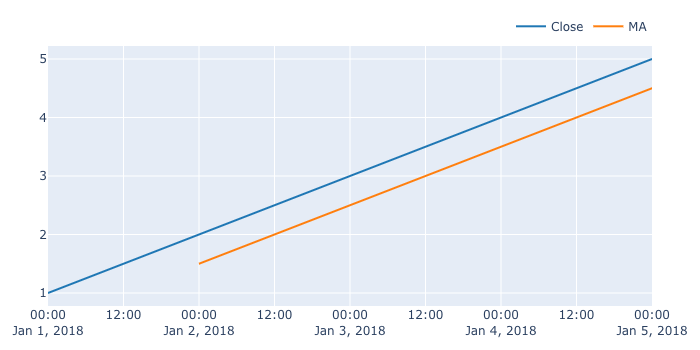

In [58]:
ma[(2, False, 'a')].plot().show_png()

## MSTD

In [59]:
print(close.rolling(2).std(ddof=0))
print(close.ewm(span=3, min_periods=3).std(ddof=0))
print(vbt.IndicatorFactory.from_talib('STDDEV').run(close, timeperiod=2).real)  
print(vbt.MSTD.run(close, [2, 3], ewm=[False, True]).mstd)  # adjust=False, ddof=0

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  0.5  0.5  0.5
2018-01-03  0.5  0.5  0.5
2018-01-04  0.5  0.5  0.5
2018-01-05  0.5  0.5  0.5
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  0.963624  0.963624  0.963624
2018-01-04  1.177164  1.177164  0.686607
2018-01-05  1.345243  1.345243  0.881714
stddev_timeperiod    2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         0.5  0.5  0.5
2018-01-03         0.5  0.5  0.5
2018-01-04         0.5  0.5  0.5
2018-01-05         0.5  0.5  0.5
mstd_window     2                   3                    
mstd_ewm    False               True                     
                a    b    c         a         b         c
2018-01-01    NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02    0.5  0.5  0.5       NaN       NaN       NaN
2018-01-03    0.5  0.5  0.5  1.048809  1.048809  1.048809
2018-01-04    0.5  

In [60]:
# One window
%timeit big_close.rolling(2).std()
%timeit vbt.IndicatorFactory.from_talib('STDDEV').run(big_close, timeperiod=2)
%timeit vbt.MSTD.run(big_close, 2)

print(vbt.MSTD.run(big_close, 2).mstd.shape)

80.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.2 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [61]:
# Multiple windows
%timeit pd.concat([big_close.rolling(i).std() for i in np.arange(2, 100)])
%timeit vbt.IndicatorFactory.from_talib('STDDEV').run(big_close, timeperiod=np.arange(2, 100))
%timeit vbt.MSTD.run(big_close, np.arange(2, 100))

print(vbt.MSTD.run(big_close, np.arange(2, 100)).mstd.shape)

9.45 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.74 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.91 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [62]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('STDDEV').run(big_close, timeperiod=np.full(100, 2))
%timeit vbt.MSTD.run(big_close, window=np.full(100, 2))

print(vbt.MSTD.run(big_close, window=np.full(100, 2)).close.shape)

739 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
610 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [63]:
mstd = vbt.MSTD.run(close, [2, 3], [False, True])

print(mstd.mstd)

mstd_window     2                   3                    
mstd_ewm    False               True                     
                a    b    c         a         b         c
2018-01-01    NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02    0.5  0.5  0.5       NaN       NaN       NaN
2018-01-03    0.5  0.5  0.5  1.048809  1.048809  1.048809
2018-01-04    0.5  0.5  0.5  1.300183  1.300183  0.740013
2018-01-05    0.5  0.5  0.5  1.469294  1.469294  0.864326


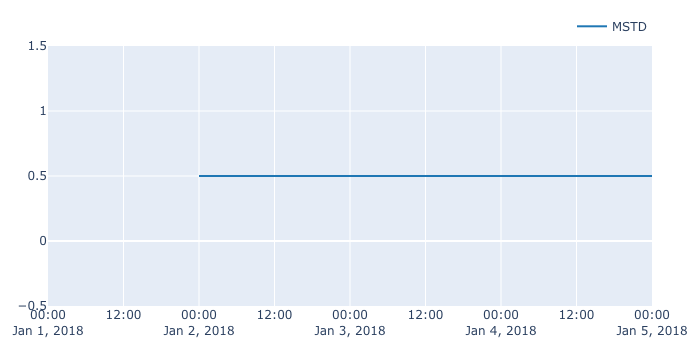

In [64]:
mstd[(2, False, 'a')].plot().show_png()

## BBANDS

In [65]:
print(ta.volatility.BollingerBands(close=close['a'], n=2, ndev=2).bollinger_hband())
print(ta.volatility.BollingerBands(close=close['a'], n=2, ndev=2).bollinger_mavg())
print(ta.volatility.BollingerBands(close=close['a'], n=2, ndev=2).bollinger_lband())

print(vbt.IndicatorFactory.from_talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).upperband)
print(vbt.IndicatorFactory.from_talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).middleband)
print(vbt.IndicatorFactory.from_talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).lowerband)

print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).upper)
print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).middle)
print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).lower)

2018-01-01    NaN
2018-01-02    2.5
2018-01-03    3.5
2018-01-04    4.5
2018-01-05    5.5
Name: hband, dtype: float64
2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
Name: mavg, dtype: float64
2018-01-01    NaN
2018-01-02    0.5
2018-01-03    1.5
2018-01-04    2.5
2018-01-05    3.5
Name: lband, dtype: float64
bbands_timeperiod    2          
bbands_nbdevup       2          
bbands_nbdevdn       2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         2.5  5.5  2.5
2018-01-03         3.5  4.5  3.5
2018-01-04         4.5  3.5  3.5
2018-01-05         5.5  2.5  2.5
bbands_timeperiod    2          
bbands_nbdevup       2          
bbands_nbdevdn       2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         1.5  4.5  1.5
2018-01-03         2.5  3.5  2.5
2018-01-04         3.5  2.5  2.5
2018-01-05         4.5  1.5  1.5
bbands_timeperiod    2          
bbands_nbdevup      

In [66]:
# One window
%timeit vbt.IndicatorFactory.from_talib('BBANDS').run(big_close, timeperiod=2)
%timeit vbt.BBANDS.run(big_close, window=2)

print(vbt.BBANDS.run(big_close).close.shape)

48.3 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.8 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [67]:
# Multiple windows
%timeit vbt.IndicatorFactory.from_talib('BBANDS').run(big_close, timeperiod=np.arange(2, 100))
%timeit vbt.BBANDS.run(big_close, window=np.arange(2, 100))

print(vbt.BBANDS.run(big_close, window=np.arange(2, 100)).close.shape)

7.51 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.67 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [68]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('BBANDS').run(big_close, timeperiod=np.full(100, 2))
%timeit vbt.BBANDS.run(big_close, window=np.full(100, 2))

print(vbt.BBANDS.run(big_close, window=np.full(100, 2)).close.shape)

2.67 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.02 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [69]:
bb = vbt.BBANDS.run(close, window=2, alpha=[1., 2.], ewm=False)

print(bb.middle)
print()
print(bb.upper)
print()
print(bb.lower)
print()
print(bb.percent_b)
print()
print(bb.bandwidth)

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   1.5  4.5  1.5  1.5  4.5  1.5
2018-01-03   2.5  3.5  2.5  2.5  3.5  2.5
2018-01-04   3.5  2.5  2.5  3.5  2.5  2.5
2018-01-05   4.5  1.5  1.5  4.5  1.5  1.5

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   2.0  5.0  2.0  2.5  5.5  2.5
2018-01-03   3.0  4.0  3.0  3.5  4.5  3.5
2018-01-04   4.0  3.0  3.0  4.5  3.5  3.5
2018-01-05   5.0  2.0  2.0  5.5  2.5  2.5

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   1.0  4.0  1.0  0.5 

In [70]:
print(bb.close_below(bb.upper) & bb.close_above(bb.lower)) # price between bands

bb_window       2                                   
bb_ewm      False                                   
bb_alpha      1.0                  2.0              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False   True   True   True
2018-01-03  False  False  False   True   True   True
2018-01-04  False  False  False   True   True   True
2018-01-05  False  False  False   True   True   True


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:417: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:417: RuntimeWarning:

invalid value encountered in greater



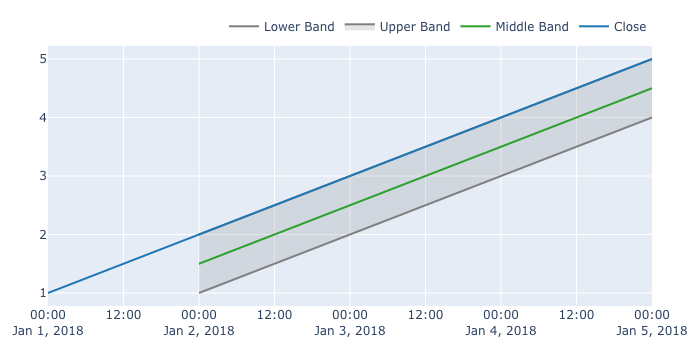

In [71]:
bb[(2, False, 1., 'a')].plot().show_png()

## RSI

In [72]:
print(ta.momentum.RSIIndicator(close=close['a'], n=2).rsi())  # alpha=1/n
print(ta.momentum.RSIIndicator(close=close['b'], n=2).rsi())
print(ta.momentum.RSIIndicator(close=close['c'], n=2).rsi())
print(vbt.IndicatorFactory.from_talib('RSI').run(close, timeperiod=2).real)
print(vbt.RSI.run(close, window=[2, 2], ewm=[True, False]).rsi)  # span=n

2018-01-01      NaN
2018-01-02    100.0
2018-01-03    100.0
2018-01-04    100.0
2018-01-05    100.0
Name: rsi, dtype: float64
2018-01-01    NaN
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
Name: rsi, dtype: float64
2018-01-01           NaN
2018-01-02    100.000000
2018-01-03    100.000000
2018-01-04     42.857143
2018-01-05     20.000000
Name: rsi, dtype: float64
rsi_timeperiod      2            
                    a    b      c
2018-01-01        NaN  NaN    NaN
2018-01-02        NaN  NaN    NaN
2018-01-03      100.0  0.0  100.0
2018-01-04      100.0  0.0   50.0
2018-01-05      100.0  0.0   25.0
rsi_window      2                                    
rsi_ewm     True                    False            
                a    b           c      a    b      c
2018-01-01    NaN  NaN         NaN    NaN  NaN    NaN
2018-01-02    NaN  NaN         NaN    NaN  NaN    NaN
2018-01-03  100.0  0.0  100.000000  100.0  0.0  100.0
2018-01-04  100.0  0.0   33.333333  100.0  0.

In [73]:
# One window
%timeit vbt.IndicatorFactory.from_talib('RSI').run(big_close, timeperiod=2)
%timeit vbt.RSI.run(big_close, window=2)

print(vbt.RSI.run(big_close, window=2).rsi.shape)

25.2 ms ± 863 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.9 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [74]:
# Multiple windows
%timeit vbt.IndicatorFactory.from_talib('RSI').run(big_close, timeperiod=np.arange(2, 100))
%timeit vbt.RSI.run(big_close, window=np.arange(2, 100))

print(vbt.RSI.run(big_close, window=np.arange(2, 100)).rsi.shape)

3.49 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.35 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [75]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('RSI').run(big_close, timeperiod=np.full(100, 2))
%timeit vbt.RSI.run(big_close, window=np.full(100, 2))

print(vbt.RSI.run(big_close, window=np.full(100, 2)).rsi.shape)

684 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.11 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [76]:
rsi = vbt.RSI.run(close, window=[2, 3], ewm=[False, True])

print(rsi.rsi)

rsi_window      2                  3           
rsi_ewm     False              True            
                a    b      c      a    b     c
2018-01-01    NaN  NaN    NaN    NaN  NaN   NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN   NaN
2018-01-03  100.0  0.0  100.0    NaN  NaN   NaN
2018-01-04  100.0  0.0   50.0  100.0  0.0  50.0
2018-01-05  100.0  0.0    0.0  100.0  0.0  25.0


In [77]:
print(rsi.rsi_above(70))

rsi_window      2                    3              
rsi_ewm     False                True               
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04   True  False  False   True  False  False
2018-01-05   True  False  False   True  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:417: RuntimeWarning:

invalid value encountered in greater



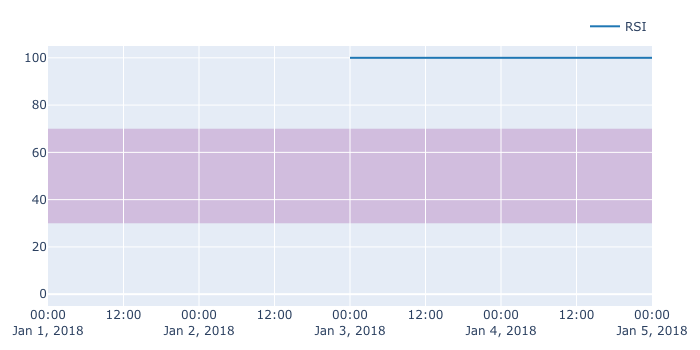

In [78]:
rsi[(2, False, 'a')].plot().show_png()

## STOCH

In [79]:
print(ta.momentum.StochasticOscillator(high=high['a'], low=low['a'], close=close['a'], n=2, d_n=3).stoch())
print(ta.momentum.StochasticOscillator(high=high['a'], low=low['a'], close=close['a'], n=2, d_n=3).stoch_signal())
print(vbt.IndicatorFactory.from_talib('STOCHF').run(
    high, low, close, fastk_period=2, fastd_period=3).fastk)
print(vbt.IndicatorFactory.from_talib('STOCHF').run(
    high, low, close, fastk_period=2, fastd_period=3).fastd)
print(vbt.STOCH.run(high, low, close, k_window=2, d_window=3).percent_k)
print(vbt.STOCH.run(high, low, close, k_window=2, d_window=3).percent_d)

2018-01-01          NaN
2018-01-02    90.033913
2018-01-03    98.459370
2018-01-04    81.624981
2018-01-05    74.524237
Name: stoch_k, dtype: float64
2018-01-01          NaN
2018-01-02          NaN
2018-01-03          NaN
2018-01-04    90.039421
2018-01-05    84.869529
Name: stoch_k_signal, dtype: float64
stochf_fastk_period          2                     
stochf_fastd_period          3                     
                             a         b          c
2018-01-01                 NaN       NaN        NaN
2018-01-02                 NaN       NaN        NaN
2018-01-03                 NaN       NaN        NaN
2018-01-04           81.624981  3.297837  11.941605
2018-01-05           74.524237  3.900804   7.395659
stochf_fastk_period          2                      
stochf_fastd_period          3                      
                             a          b          c
2018-01-01                 NaN        NaN        NaN
2018-01-02                 NaN        NaN        NaN
2018-01-03  

In [80]:
# One window
%timeit vbt.IndicatorFactory.from_talib('STOCHF').run(\
    big_high, big_low, big_close, fastk_period=2)
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=2)

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=2).percent_d.shape)

53.8 ms ± 650 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.3 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [81]:
# Multiple windows
%timeit vbt.IndicatorFactory.from_talib('STOCHF').run(\
    big_high, big_low, big_close, fastk_period=np.arange(2, 100))
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=np.arange(2, 100))

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=np.arange(2, 100)).percent_d.shape)

6.2 s ± 54.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.5 s ± 895 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [82]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('STOCHF').run(\
    big_high, big_low, big_close, fastk_period=np.full(100, 2))
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=np.full(100, 2))

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=np.full(100, 2)).percent_d.shape)

1.45 s ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.02 s ± 243 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [83]:
stochastic = vbt.STOCH.run(high, low, close, k_window=[2, 4], d_window=2, d_ewm=[False, True])

print(stochastic.percent_k)
print(stochastic.percent_d)

stoch_k_window          2                                4            \
stoch_d_window          2                                2             
stoch_d_ewm         False                            True              
                        a          b          c          a         b   
2018-01-01            NaN        NaN        NaN        NaN       NaN   
2018-01-02      90.033913  16.118819  97.107794        NaN       NaN   
2018-01-03      98.459370  16.658503  85.664573        NaN       NaN   
2018-01-04      81.624981   3.297837  11.941605  91.582811  1.221173   
2018-01-05      74.524237   3.900804   7.395659  88.208468  1.313450   

stoch_k_window             
stoch_d_window             
stoch_d_ewm                
                        c  
2018-01-01            NaN  
2018-01-02            NaN  
2018-01-03            NaN  
2018-01-04      47.019332  
2018-01-05       4.190157  
stoch_k_window          2                                4            \
stoch_d_window          2  

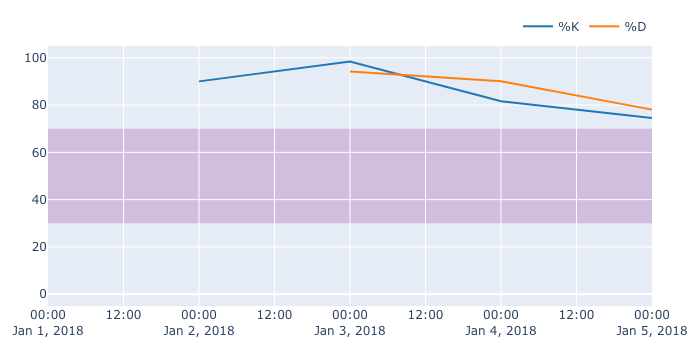

In [84]:
stochastic[(2, 2, False, 'a')].plot().show_png()

## MACD

In [85]:
print(ta.trend.MACD(close['a'], n_fast=2, n_slow=3, n_sign=2).macd())
print(ta.trend.MACD(close['a'], n_fast=2, n_slow=3, n_sign=2).macd_signal())
print(ta.trend.MACD(close['a'], n_fast=2, n_slow=3, n_sign=2).macd_diff())

print(vbt.IndicatorFactory.from_talib('MACD').run(
    close, fastperiod=2, slowperiod=3, signalperiod=2).macd)  # uses sma
print(vbt.IndicatorFactory.from_talib('MACD').run(
    close, fastperiod=2, slowperiod=3, signalperiod=2).macdsignal)
print(vbt.IndicatorFactory.from_talib('MACD').run(
    close, fastperiod=2, slowperiod=3, signalperiod=2).macdhist)

print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).macd)
print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).hist)

2018-01-01         NaN
2018-01-02         NaN
2018-01-03    0.305556
2018-01-04    0.393519
2018-01-05    0.443673
Name: MACD_2_3, dtype: float64
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04    0.364198
2018-01-05    0.417181
Name: MACD_sign_2_3, dtype: float64
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04    0.029321
2018-01-05    0.026492
Name: MACD_diff_2_3, dtype: float64
macd_fastperiod      2               
macd_slowperiod      3               
macd_signalperiod    2               
                     a    b         c
2018-01-01         NaN  NaN       NaN
2018-01-02         NaN  NaN       NaN
2018-01-03         NaN  NaN       NaN
2018-01-04         0.5 -0.5  0.166667
2018-01-05         0.5 -0.5 -0.111111
macd_fastperiod      2               
macd_slowperiod      3               
macd_signalperiod    2               
                     a    b         c
2018-01-01         NaN  NaN       NaN
2018-01-02         N

In [7]:
# One window
%timeit vbt.IndicatorFactory.from_talib('MACD').run(big_close, fastperiod=2)
%timeit vbt.MACD.run(big_close, fast_window=2)

print(vbt.MACD.run(big_close, fast_window=2).macd.shape)

50.9 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.8 ms ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [8]:
# Multiple windows
%timeit vbt.IndicatorFactory.from_talib('MACD').run(big_close, fastperiod=np.arange(2, 100))
%timeit vbt.MACD.run(big_close, fast_window=np.arange(2, 100))

print(vbt.MACD.run(big_close, fast_window=np.arange(2, 100)).macd.shape)

8.1 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.65 s ± 37.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [88]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('MACD').run(big_close, fastperiod=np.full(100, 2))
%timeit vbt.MACD.run(big_close, fast_window=np.full(100, 2))

print(vbt.MACD.run(big_close, fast_window=np.full(100, 2)).macd.shape)

2.14 s ± 74.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.79 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [9]:
macd = vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=[2, 3], macd_ewm=True, signal_ewm=True)

print(macd.macd)
print(macd.signal)
print(macd.hist)

macd_fast_window           2                                                  
macd_slow_window           3                                                  
macd_signal_window         2                             3                    
macd_macd_ewm           True                          True                    
macd_signal_ewm         True                          True                    
                           a         b         c         a         b         c
2018-01-01               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-03          0.305556 -0.305556  0.305556  0.305556 -0.305556  0.305556
2018-01-04          0.393519 -0.393519  0.060185  0.393519 -0.393519  0.060185
2018-01-05          0.443673 -0.443673 -0.167438  0.443673 -0.443673 -0.167438
macd_fast_window           2                                                  
macd_slow_window           3                        

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:594: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:595: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:595: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:596: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:597: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:597: RuntimeWarning:

invalid value encountered in greater_equal



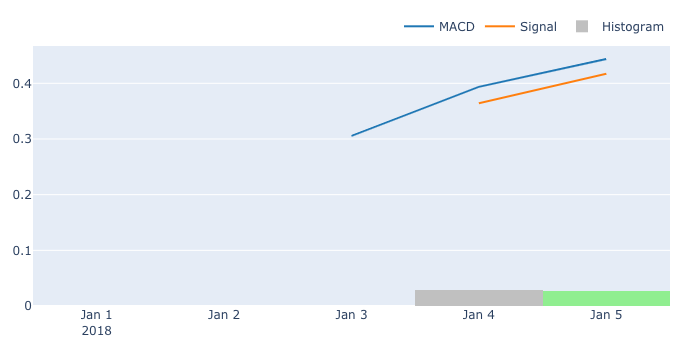

In [90]:
macd[(2, 3, 2, True, True, 'a')].plot().show_png()

## ATR

In [91]:
print(ta.volatility.AverageTrueRange(high['a'], low['a'], close['a'], n=2).average_true_range())
print(ta.volatility.AverageTrueRange(high['b'], low['b'], close['b'], n=2).average_true_range())
print(ta.volatility.AverageTrueRange(high['c'], low['c'], close['c'], n=2).average_true_range())
print(vbt.IndicatorFactory.from_talib('ATR').run(high, low, close, timeperiod=2).real)
print(vbt.ATR.run(high, low, close, window=[2, 3], ewm=[False, True]).atr)

2018-01-01    0.000000
2018-01-02    0.619423
2018-01-03    0.818424
2018-01-04    1.050826
2018-01-05    1.233524
Name: atr, dtype: float64
2018-01-01    0.000000
2018-01-02    1.053372
2018-01-03    1.132864
2018-01-04    1.087915
2018-01-05    1.064337
Name: atr, dtype: float64
2018-01-01    0.000000
2018-01-02    0.575961
2018-01-03    0.878148
2018-01-04    1.019107
2018-01-05    1.057231
Name: atr, dtype: float64
atr_timeperiod         2                    
                       a         b         c
2018-01-01           NaN       NaN       NaN
2018-01-02           NaN       NaN       NaN
2018-01-03      1.068578  1.247932  1.105767
2018-01-04      1.175904  1.145449  1.132916
2018-01-05      1.296063  1.093104  1.114135
atr_window         2                             3                    
atr_ewm        False                         True                     
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       Na

In [92]:
# One window
%timeit vbt.IndicatorFactory.from_talib('ATR').run(big_high, big_low, big_close, timeperiod=2)
%timeit vbt.ATR.run(big_high, big_low, big_close, window=2)

print(vbt.ATR.run(big_high, big_low, big_close, window=2).atr.shape)

39.3 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.5 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [93]:
# Multiple windows
%timeit vbt.IndicatorFactory.from_talib('ATR').run(big_high, big_low, big_close, timeperiod=np.arange(2, 100))
%timeit vbt.ATR.run(big_high, big_low, big_close, window=np.arange(2, 100)) # rolling min/max very expensive

print(vbt.ATR.run(big_high, big_low, big_close, window=np.arange(2, 100)).atr.shape)

4.32 s ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.83 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [94]:
# One window repeated
%timeit vbt.IndicatorFactory.from_talib('ATR').run(big_high, big_low, big_close, timeperiod=np.full(100, 2))
%timeit vbt.ATR.run(big_high, big_low, big_close, window=np.full(100, 2))

print(vbt.ATR.run(big_high, big_low, big_close, window=np.full(100, 2)).atr.shape)

The slowest run took 5.23 times longer than the fastest. This could mean that an intermediate result is being cached.
1.3 s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.13 s ± 5.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [95]:
atr = vbt.ATR.run(high, low, close, window=[2, 3], ewm=[False, True])

print(atr.tr)
print(atr.atr)

atr_window         2                             3                    
atr_ewm        False                         True                     
                   a         b         c         a         b         c
2018-01-01  0.119114  0.823236  0.120724  0.119114  0.823236  0.120724
2018-01-02  1.119732  1.283508  1.031199  1.119732  1.283508  1.031199
2018-01-03  1.017425  1.212357  1.180335  1.017425  1.212357  1.180335
2018-01-04  1.283229  1.042965  1.160065  1.283229  1.042965  1.160065
2018-01-05  1.416221  1.040759  1.095355  1.416221  1.040759  1.095355
atr_window         2                             3                    
atr_ewm        False                         True                     
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  0.619423  1.053372  0.575961       NaN       NaN       NaN
2018-01-03  1.068578  1.247932  1.105767  0.818424  1.132864  0.878148
2018-0

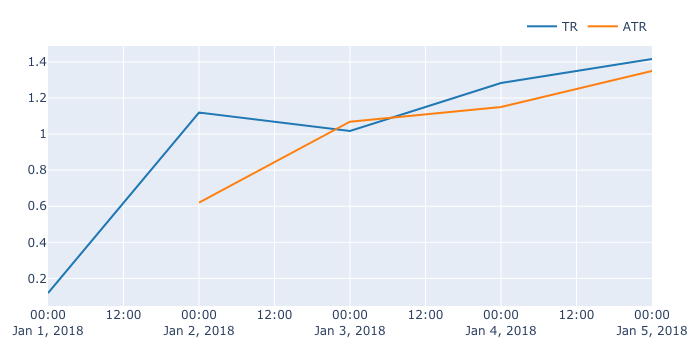

In [96]:
atr[(2, False, 'a')].plot().show_png()

## OBV

In [97]:
print(ta.volume.OnBalanceVolumeIndicator(close['a'], volume['a']).on_balance_volume())
print(ta.volume.OnBalanceVolumeIndicator(close['b'], volume['b']).on_balance_volume())
print(ta.volume.OnBalanceVolumeIndicator(close['c'], volume['c']).on_balance_volume())
print(vbt.IndicatorFactory.from_talib('OBV').run(close, volume).real)
print(vbt.OBV.run(close, volume).obv)

2018-01-01     60.0
2018-01-02    142.0
2018-01-03    155.0
2018-01-04    178.0
2018-01-05    240.0
Name: obv, dtype: float64
2018-01-01     16.0
2018-01-02    -32.0
2018-01-03   -130.0
2018-01-04   -148.0
2018-01-05   -159.0
Name: obv, dtype: float64
2018-01-01     30.0
2018-01-02     57.0
2018-01-03    126.0
2018-01-04     27.0
2018-01-05    -66.0
Name: obv, dtype: float64
                a      b      c
2018-01-01   60.0   16.0   30.0
2018-01-02  142.0  -32.0   57.0
2018-01-03  155.0 -130.0  126.0
2018-01-04  178.0 -148.0   27.0
2018-01-05  240.0 -159.0  -66.0
                a      b      c
2018-01-01   60.0   16.0   30.0
2018-01-02  142.0  -32.0   57.0
2018-01-03  155.0 -130.0  126.0
2018-01-04  178.0 -148.0   27.0
2018-01-05  240.0 -159.0  -66.0


In [98]:
%timeit vbt.IndicatorFactory.from_talib('OBV').run(big_close, big_volume)
%timeit vbt.OBV.run(big_close, big_volume)

print(vbt.OBV.run(big_close, big_volume).obv.shape)

25.3 ms ± 654 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.1 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [99]:
obv = vbt.OBV.run(close, volume)

print(obv.obv)

                a      b      c
2018-01-01   60.0   16.0   30.0
2018-01-02  142.0  -32.0   57.0
2018-01-03  155.0 -130.0  126.0
2018-01-04  178.0 -148.0   27.0
2018-01-05  240.0 -159.0  -66.0


In [100]:
print(obv.obv_above([0, 5], multiple=True))

obv_above      0                   5              
               a      b      c     a      b      c
2018-01-01  True   True   True  True   True   True
2018-01-02  True  False   True  True  False   True
2018-01-03  True  False   True  True  False   True
2018-01-04  True  False   True  True  False   True
2018-01-05  True  False  False  True  False  False


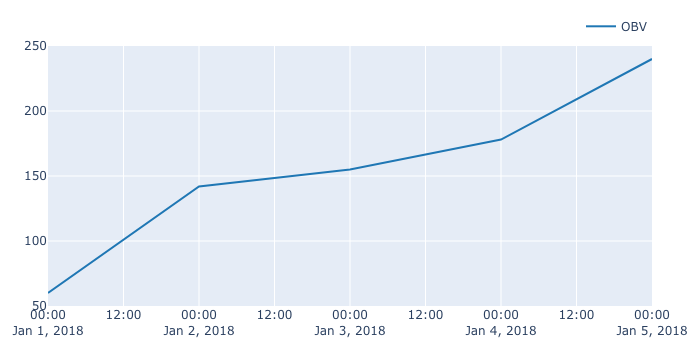

In [101]:
obv['a'].plot().show_png()